# Setup and import libraries

Lets install the tesseract library

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (4,353 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fro

In [2]:
from PIL import Image, ImageDraw
import pytesseract
import inspect
from ipywidgets import interact

In [3]:
# @interact(left=100, top=100, right=200, bottom=200)

# Base case
Lets play around with a *Basecase*. A simple image with big and clear text. 

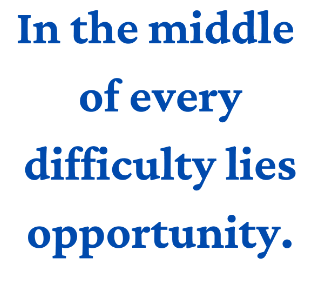

In [4]:
img = Image.open('sample2.png')
display(img)

Lets use the dir function to see what we get with the pytesseract library.

In [5]:
dir(pytesseract)

['ALTONotSupported',
 'Output',
 'TSVNotSupported',
 'TesseractError',
 'TesseractNotFoundError',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'get_languages',
 'get_tesseract_version',
 'image_to_alto_xml',
 'image_to_boxes',
 'image_to_data',
 'image_to_osd',
 'image_to_pdf_or_hocr',
 'image_to_string',
 'pytesseract',
 'run_and_get_output']

To apply topological sort we need to get the bounding boxes around the text lines. For the `image_to_boxes()` function and `image_to_data()` function seems to be our best bet.

In [6]:
src = inspect.getsource(pytesseract.image_to_boxes)
print(src)

def image_to_boxes(
    image,
    lang=None,
    config='',
    nice=0,
    output_type=Output.STRING,
    timeout=0,
):
    """
    Returns string containing recognized characters and their box boundaries
    """
    config = f'{config.strip()} batch.nochop makebox'
    args = [image, 'box', lang, config, nice, timeout]

    return {
        Output.BYTES: lambda: run_and_get_output(*(args + [True])),
        Output.DICT: lambda: file_to_dict(
            f'char left bottom right top page\n{run_and_get_output(*args)}',
            ' ',
            0,
        ),
        Output.STRING: lambda: run_and_get_output(*args),
    }[output_type]()



In [7]:
src = inspect.getsource(pytesseract.image_to_data)
print(src)

def image_to_data(
    image,
    lang=None,
    config='',
    nice=0,
    output_type=Output.STRING,
    timeout=0,
    pandas_config=None,
):
    """
    Returns string containing box boundaries, confidences,
    and other information. Requires Tesseract 3.05+
    """

    if get_tesseract_version() < TESSERACT_MIN_VERSION:
        raise TSVNotSupported()

    config = f'-c tessedit_create_tsv=1 {config.strip()}'
    args = [image, 'tsv', lang, config, nice, timeout]

    return {
        Output.BYTES: lambda: run_and_get_output(*(args + [True])),
        Output.DATAFRAME: lambda: get_pandas_output(
            args + [True],
            pandas_config,
        ),
        Output.DICT: lambda: file_to_dict(run_and_get_output(*args), '\t', -1),
        Output.STRING: lambda: run_and_get_output(*args),
    }[output_type]()



In [8]:
bounding_boxes = pytesseract.image_to_boxes(img)
print(bounding_boxes)

I 18 240 31 268 0
n 33 240 60 261 0
t 70 239 88 266 0
h 88 240 115 273 0
e 118 239 137 261 0
m 149 240 189 261 0
i 161 239 205 273 0
d 190 240 203 273 0
d 206 239 230 273 0
l 232 239 257 273 0
e 258 239 293 273 0
o 80 171 102 193 0
f 104 172 123 205 0
e 131 171 150 193 0
v 152 171 176 193 0
e 177 171 197 193 0
r 182 161 218 193 0
y 199 161 242 193 0
d 25 103 50 137 0
i 29 93 65 137 0
f 51 103 64 136 0
f 65 103 83 137 0
i 81 103 110 137 0
c 112 103 132 125 0
u 116 93 151 137 0
l 133 103 160 125 0
t 160 103 174 137 0
y 175 93 216 129 0
l 226 103 239 137 0
i 240 103 253 136 0
e 255 103 275 125 0
s 279 103 295 125 0
o 28 35 50 57 0
p 52 25 77 57 0
p 54 24 98 68 0
o 79 25 104 57 0
r 107 35 130 57 0
t 132 35 150 56 0
u 151 35 168 61 0
n 169 35 196 56 0
i 197 35 224 57 0
t 225 35 238 68 0
y 239 35 256 61 0
. 256 24 292 56 0



**Since `image_to_boxes()` function returns characters and `image_to_data()` returns bounding boxes for whole words lets go with the `image_to_data()` function.**

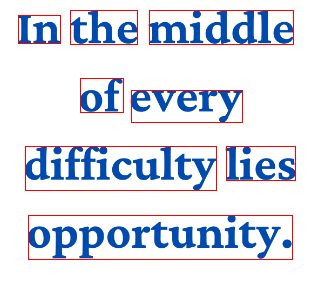

In [9]:
boxes = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
draw = ImageDraw.Draw(img)

for i, text in enumerate(boxes['text']):
    if text.strip():
        left = boxes['left'][i]
        top = boxes['top'][i]
        width = boxes['width'][i]
        height = boxes['height'][i]
        draw.rectangle(((left, top), (left + width, top + height)), outline='red')

img.show()

In [10]:
print(boxes)

{'level': [1, 2, 3, 4, 5, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4], 'word_num': [0, 0, 0, 0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 0, 1], 'left': [0, 18, 18, 18, 18, 70, 149, 80, 80, 131, 25, 25, 226, 28, 28], 'top': [0, 10, 10, 10, 15, 10, 10, 78, 78, 90, 146, 146, 146, 215, 215], 'width': [318, 277, 277, 275, 42, 67, 144, 162, 43, 111, 270, 191, 69, 264, 264], 'height': [283, 249, 249, 34, 28, 34, 34, 44, 34, 32, 44, 44, 34, 44, 44], 'conf': [-1, -1, -1, -1, 96, 96, 95, -1, 96, 96, -1, 96, 96, -1, 96], 'text': ['', '', '', '', 'In', 'the', 'middle', '', 'of', 'every', '', 'difficulty', 'lies', '', 'opportunity.']}


the bounding boxes cover words. we want them to cover the whole text line to make our job easier.

In [11]:
print(list(boxes.keys()))

['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text']


Lets remove the text with negative confidence score.

In [12]:
def clean_data(boxes):
  index = list(range(len(boxes['conf'])))
  for idx, i in enumerate(boxes['conf']):
    if i<0:
      index.remove(idx)

  # new bounding boxes
  new_boxes = {}
  for key in boxes.keys():
    new_boxes[key] = []
    for i in index:
      new_boxes[key].append(boxes[key][i])
  return new_boxes

In [13]:
# print the new boxes dictionary
new_boxes = clean_data(boxes)
print(new_boxes)

{'level': [5, 5, 5, 5, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [1, 1, 1, 1, 1, 1, 1, 1], 'par_num': [1, 1, 1, 1, 1, 1, 1, 1], 'line_num': [1, 1, 1, 2, 2, 3, 3, 4], 'word_num': [1, 2, 3, 1, 2, 1, 2, 1], 'left': [18, 70, 149, 80, 131, 25, 226, 28], 'top': [15, 10, 10, 78, 90, 146, 146, 215], 'width': [42, 67, 144, 43, 111, 191, 69, 264], 'height': [28, 34, 34, 34, 32, 44, 34, 44], 'conf': [96, 96, 95, 96, 96, 96, 96, 96], 'text': ['In', 'the', 'middle', 'of', 'every', 'difficulty', 'lies', 'opportunity.']}


Lets split the dictionary to different lines according to the dictionary key `line_num`.

In [14]:
lines = set(new_boxes['line_num'])
print(lines)

{1, 2, 3, 4}


In [15]:
# function to seperate the blocks
def seperate_blocks(boxes):
  blocks = []
  for line in set(boxes['block_num']):
    blocks.append({})
  for key in boxes.keys():
    for val, bx in zip(boxes[key], boxes['block_num']):
      try:
        blocks[bx-1][key].append(val)
      except:
        blocks[bx-1][key] = [val]
  return blocks

In [16]:
def seperate_lines(blocks):
  new_blocks = []
  for block in blocks:
    text_lines = []
    for line in set(block['line_num']):
      text_lines.append({})
    for key in block.keys():
      for val, ln in zip(block[key], block['line_num']):
        try:
          text_lines[ln-1][key].append(val)
        except:
          text_lines[ln-1][key] = [val]
    new_blocks.append(text_lines)
  return new_blocks

In [17]:
image = Image.open("SamplePaper1.png")
boxes = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
boxes = clean_data(boxes)

In [18]:
blocks = seperate_blocks(boxes)
print(max(blocks[0]['line_num']))

22


In [19]:
print(blocks[0].keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [20]:
tl = seperate_lines(blocks)
print(tl)

[[{'level': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'par_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'line_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'word_num': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 'left': [28, 57, 98, 115, 158, 192, 208, 226, 278, 306, 337, 376, 389, 452, 507, 561], 'top': [13, 18, 16, 18, 13, 16, 13, 13, 13, 18, 13, 18, 13, 13, 13, 16], 'width': [24, 37, 13, 39, 31, 12, 14, 47, 24, 27, 35, 10, 59, 51, 50, 67], 'height': [12, 11, 9, 7, 15, 9, 12, 15, 12, 7, 12, 7, 16, 12, 16, 13], 'conf': [94, 92, 92, 96, 95, 95, 93, 88, 96, 96, 91, 96, 96, 95, 93, 92], 'text': ['and', 'prone', 'to', 'errors', '(Naz', 'et', 'al.', '2015b).', 'The', 'new', 'trend', 'is', 'diverting', 'towards', 'implicit', 'segmenta-']}, {'level': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 

In [21]:
len(tl[0])

22

In [22]:
def get_bounding_boxes(image, text_lines):
  draw = ImageDraw.Draw(image)
  for text_line in text_lines:
    # if text.strip():
    left = min(text_line['left'])
    top = min(text_line['top'])
    width = text_line['left'][-1] + text_line['width'][-1] - text_line['left'][0]
    height = max(text_line['height'])
    draw.rectangle(((left, top), (left + width, top + height)), outline='red')

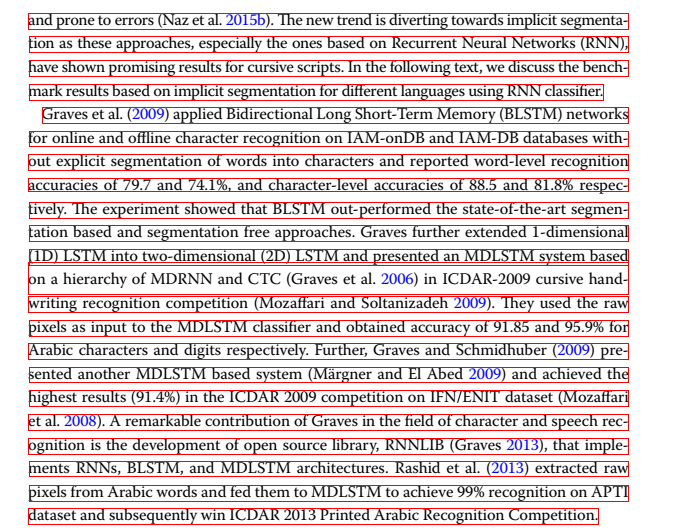

In [23]:
for textLine in tl:
  get_bounding_boxes(image, textLine)
display(image)

Lets make the example more complex. \
**Example 1**

In [24]:
image2 = Image.open('SamplePaper1.png')
boxes = pytesseract.image_to_data(image2, output_type=pytesseract.Output.DICT)
boxes = clean_data(boxes)
blocks = seperate_blocks(boxes)
text_lines = seperate_lines(blocks)
for text_line in text_lines:
  get_bounding_boxes(image2, text_line)

In [25]:
print(len(text_lines))

1


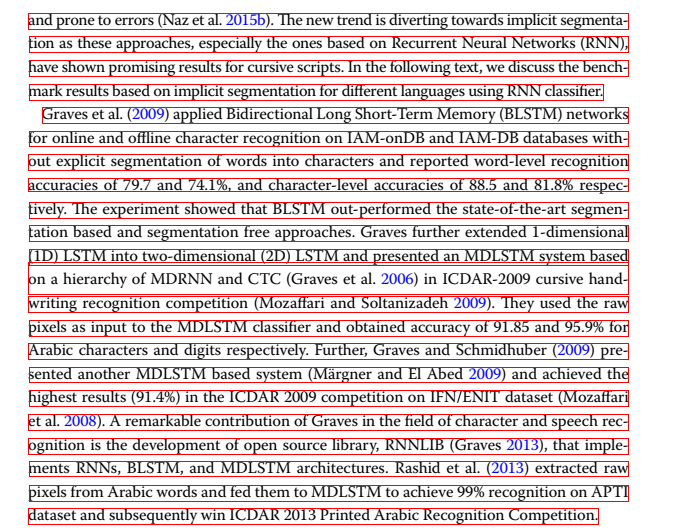

In [26]:
display(image2)

**Example 2**

In [27]:
image3 = Image.open('p4.jpg')
boxes = pytesseract.image_to_data(image3, output_type=pytesseract.Output.DICT)
boxes = clean_data(boxes)
blocks = seperate_blocks(boxes)
text_lines = seperate_lines(blocks)
len(text_lines)

25

There are 25 blocks in the page. Lets draw lines on each of the blocks step by step.

In [ ]:
for text_line in text_lines:
  get_bounding_boxes(image3, text_line)
  display(image3)

# Constructing the graph

Lets make the adjacency list. \
For this we need to make have an id for each text line. The node of each graph can be a that id and the id can be index value of the individual line.

In [68]:
# ids can be the indexes of the lines. Since the text lines are already sorted by pytesseract, the index 
# of the nodes will also be in sorted order according to the where they occur in the document.
def make_list(text_lines):
    lines = []
    for block in text_lines:
      for line in block:
        lines.append(line)
    return lines

In [69]:
print(text_lines)

[[{'level': [5], 'page_num': [1], 'block_num': [1], 'par_num': [1], 'line_num': [1], 'word_num': [1], 'left': [55], 'top': [53], 'width': [32], 'height': [11], 'conf': [91], 'text': ['2374']}], [{'level': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'par_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'line_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'word_num': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'left': [326, 362, 480, 497, 566, 646, 679, 744, 875, 946, 1009, 1087], 'top': [53, 53, 53, 45, 45, 53, 45, 45, 53, 53, 53, 45], 'width': [32, 113, 21, 70, 76, 29, 58, 114, 54, 46, 79, 39], 'height': [11, 11, 11, 28, 28, 11, 28, 28, 13, 12, 11, 28], 'conf': [94, 96, 96, 96, 96, 96, 95, 92, 92, 92, 64, 64], 'text': ['IEEE', 'TRANSACTIONS', 'ON', 'PATTERN', 'ANALYSIS', 'AND', 'MACHINE', 'INTELLIGENCE,', 'VOL.38,', 'NO.12,', 'DECEMBER', '2016']}], [{'level': [5, 5, 5], 'page_num': [1, 1, 1], 'block_num

In [70]:
list_of_lines = make_list(text_lines)
print(list_of_lines)

[{'level': [5], 'page_num': [1], 'block_num': [1], 'par_num': [1], 'line_num': [1], 'word_num': [1], 'left': [55], 'top': [53], 'width': [32], 'height': [11], 'conf': [91], 'text': ['2374']}, {'level': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'par_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'line_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'word_num': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'left': [326, 362, 480, 497, 566, 646, 679, 744, 875, 946, 1009, 1087], 'top': [53, 53, 53, 45, 45, 53, 45, 45, 53, 53, 53, 45], 'width': [32, 113, 21, 70, 76, 29, 58, 114, 54, 46, 79, 39], 'height': [11, 11, 11, 28, 28, 11, 28, 28, 13, 12, 11, 28], 'conf': [94, 96, 96, 96, 96, 96, 95, 92, 92, 92, 64, 64], 'text': ['IEEE', 'TRANSACTIONS', 'ON', 'PATTERN', 'ANALYSIS', 'AND', 'MACHINE', 'INTELLIGENCE,', 'VOL.38,', 'NO.12,', 'DECEMBER', '2016']}, {'level': [5, 5, 5], 'page_num': [1, 1, 1], 'block_num': [3

In [71]:
len(list_of_lines)

79

In [105]:
def assign_id(line):
  return str(line['block_num'][0])+str(line['line_num'][0])

In [95]:
# Lets demonstrate the capability of ids in finding a specific value.
# lets find the last id
def finding_line(finding, list_of_lines):
  for line in list_of_lines:
    if str(line['block_num'][0])+str(line['line_num'][0]) == finding:
      return line

In [96]:
finding = assign_id(list_of_lines[-1])
print(finding_line(finding, list_of_lines))

{'level': [5, 5, 5, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1], 'block_num': [25, 25, 25, 25, 25, 25, 25], 'par_num': [1, 1, 1, 1, 1, 1, 1], 'line_num': [2, 2, 2, 2, 2, 2, 2], 'word_num': [1, 2, 3, 4, 5, 6, 7], 'left': [322, 347, 523, 720, 746, 764, 796], 'top': [1579, 1579, 1570, 1579, 1579, 1582, 1579], 'width': [20, 177, 190, 22, 14, 27, 60], 'height': [9, 11, 28, 9, 9, 6, 9], 'conf': [91, 38, 19, 19, 96, 96, 93], 'text': ['See', 'http://wwwieee.org/publications_', 'standards/publications/rights/index', 'html', 'for', 'more', 'information.']}


Great. Each dictionary in the list is a line. \
To create a graph all we have to do is to create a dictionary. \
Since element A follows element B in the list and each element (considering the elements to be node of the graph) have one directed edge to the element that follows we get the complete graph.

In [64]:
# def construct_graph(list_of_lines):
#   graph = {}
#   for l in range(len(list_of_lines)):
#     if l != len(list_of_lines)-1:
#       graph[l] = [l+1]
#     else:
#       graph[l] = []
#   return graph

In [85]:
def construct_graph(list_of_lines):
  graph = {}
  for l in range(len(list_of_lines)):
    if l != len(list_of_lines)-1:
      graph[assign_id(list_of_lines[l])] = [assign_id(list_of_lines[l+1])]
    else:
      graph[assign_id(list_of_lines[l])] = []
  return graph

Lets **check if the graph is constructed correctly**. (all nodes have one out degree except for the last one that has 0 out degrees).

In [86]:
graph = construct_graph(list_of_lines)
bool_val = True
nodes = list(graph.keys())
for i in nodes[0:-1]:
  if len(graph[i]) != 1:
    bool_val = False
if len(graph[nodes[-1]]) != 0:
  bool_val = False

bool_val

True

In [87]:
print(graph)

{'11': ['21'], '21': ['31'], '31': ['32'], '32': ['41'], '41': ['51'], '51': ['52'], '52': ['53'], '53': ['54'], '54': ['55'], '55': ['56'], '56': ['57'], '57': ['58'], '58': ['59'], '59': ['510'], '510': ['61'], '61': ['71'], '71': ['81'], '81': ['91'], '91': ['92'], '92': ['93'], '93': ['94'], '94': ['95'], '95': ['96'], '96': ['97'], '97': ['98'], '98': ['99'], '99': ['910'], '910': ['911'], '911': ['912'], '912': ['913'], '913': ['914'], '914': ['915'], '915': ['916'], '916': ['917'], '917': ['918'], '918': ['919'], '919': ['920'], '920': ['921'], '921': ['922'], '922': ['923'], '923': ['101'], '101': ['111'], '111': ['121'], '121': ['131'], '131': ['141'], '141': ['151'], '151': ['161'], '161': ['171'], '171': ['181'], '181': ['182'], '182': ['183'], '183': ['184'], '184': ['191'], '191': ['192'], '192': ['193'], '193': ['201'], '201': ['202'], '202': ['203'], '203': ['204'], '204': ['205'], '205': ['206'], '206': ['207'], '207': ['208'], '208': ['209'], '209': ['2010'], '2010': [

The graph is constructed correctly.

# Topological Sort

Lets apply topological sort to the graph that we constructed.

In [88]:
from collections import deque

In [89]:
def topological_sort(graph):
    # lets initialize indegree and resultant list
    indegree = {node: 0 for node in graph}
    result = []
    # calculating indegree of each node
    for node in graph:
        for neighbor in graph[node]:
            indegree[neighbor] += 1
    # Initializing the queue with nodes with zero indegree
    queue = deque([node for node in indegree if indegree[node] == 0])
    # Performing topological sort
    while queue:
        node = queue.popleft()
        result.append(node)
        for neighbor in graph[node]:
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                queue.append(neighbor)
    # Check for a cycle
    if len(result) != len(graph):
        raise ValueError("Graph has at least one cycle")
    return result

In [90]:
node_sequence = topological_sort(graph)
node_sequence

['11',
 '21',
 '31',
 '32',
 '41',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '510',
 '61',
 '71',
 '81',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '910',
 '911',
 '912',
 '913',
 '914',
 '915',
 '916',
 '917',
 '918',
 '919',
 '920',
 '921',
 '922',
 '923',
 '101',
 '111',
 '121',
 '131',
 '141',
 '151',
 '161',
 '171',
 '181',
 '182',
 '183',
 '184',
 '191',
 '192',
 '193',
 '201',
 '202',
 '203',
 '204',
 '205',
 '206',
 '207',
 '208',
 '209',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '211',
 '221',
 '231',
 '241',
 '251',
 '252']

even is we shuffle the `list_of_lines` list the order is still preserved in the list `node_sequence` that we get through `topological_sort`

In [99]:
import random

my_list = list_of_lines
random.shuffle(my_list)

In [100]:
lll = []
for node in node_sequence:
  lll.append(finding_line(node, my_list))

print(lll)

[{'level': [5], 'page_num': [1], 'block_num': [1], 'par_num': [1], 'line_num': [1], 'word_num': [1], 'left': [55], 'top': [53], 'width': [32], 'height': [11], 'conf': [91], 'text': ['2374']}, {'level': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'par_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'line_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'word_num': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'left': [326, 362, 480, 497, 566, 646, 679, 744, 875, 946, 1009, 1087], 'top': [53, 53, 53, 45, 45, 53, 45, 45, 53, 53, 53, 45], 'width': [32, 113, 21, 70, 76, 29, 58, 114, 54, 46, 79, 39], 'height': [11, 11, 11, 28, 28, 11, 28, 28, 13, 12, 11, 28], 'conf': [94, 96, 96, 96, 96, 96, 95, 92, 92, 92, 64, 64], 'text': ['IEEE', 'TRANSACTIONS', 'ON', 'PATTERN', 'ANALYSIS', 'AND', 'MACHINE', 'INTELLIGENCE,', 'VOL.38,', 'NO.12,', 'DECEMBER', '2016']}, {'level': [5, 5, 5], 'page_num': [1, 1, 1], 'block_num': [3

Lets display the text.

In [102]:
for item in lll:
  print(" ".join(item['text']))

2374
IEEE TRANSACTIONS ON PATTERN ANALYSIS AND MACHINE INTELLIGENCE, VOL.38, NO.12, DECEMBER 2016
Discriminative Bayesian Dictionary
Learning for Classification
Naveed Akhtar, Faisal Shafait, and Ajmal Mian
Abstract—We propose a Bayesian approach to learn discriminative dictionaries for sparse representation of data. The proposed
approach infers probability distributions over the atoms of a discriminative dictionary using a finite approximation of Beta Process. It
also computes sets of Bernoulli distributions that associate class labels to the learned dictionary atoms. This association signifies the
selection probabilities of the dictionary atoms in the expansion of class-specific data. Furthermore, the non-parametric character of the
proposed approach allows it to infer the correct size of the dictionary. We exploit the aforementioned Bernoulli distributions in
separately learning a linear classifier. The classifier uses the same hierarchical Bayesian model as the dictionary, which we

In [118]:
def display_text(sequence, my_list):
  for node in sequence:
    ln = finding_line(node, my_list)
    print(" ".join(ln['text']))

# 2 more Examples
Lets show 2 more examples as asked by question 5.

## Example 1

In [132]:
# lets complete the example of the first somple paper that was shown first
image2 = Image.open('SamplePaper1.png')
boxes = pytesseract.image_to_data(image2, output_type=pytesseract.Output.DICT)
boxes = clean_data(boxes)
blocks = seperate_blocks(boxes)
text_lines = seperate_lines(blocks)
for text_line in text_lines:
  get_bounding_boxes(image2, text_line)

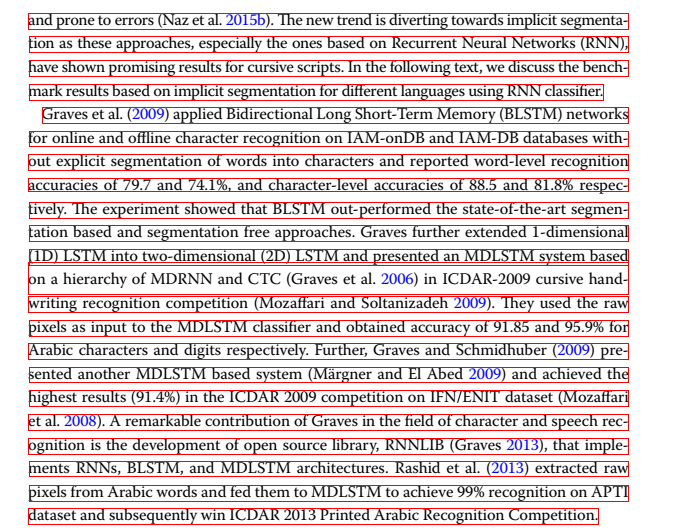

In [111]:
display(image2)

In [120]:
list_of_lines = make_list(text_lines)
graph = construct_graph(list_of_lines)
node_sequence = topological_sort(graph)
display_text(node_sequence, list_of_lines)

and prone to errors (Naz et al. 2015b). The new trend is diverting towards implicit segmenta-
tion as these approaches, especially the ones based on Recurrent Neural Networks (RNN),
have shown promising results for cursive scripts. In the following text, we discuss the bench-
mark results based on implicit segmentation for different languages using RNN classifier.
Graves et al. (2009) applied Bidirectional Long Short-Term Memory (BLSTM) networks
for online and offline character recognition on IAM-onDB and IAM-DB databases with-
out explicit segmentation of words into characters and reported word-level recognition
accuracies of 79.7 and 74.1%, and character-level accuracies of 88.5 and 81.8% respec-
tively. The experiment showed that BLSTM out-performed the state-of-the-art segmen-
tation based and segmentation free approaches. Graves further extended 1-dimensional
(1D) LSTM into two-dimensional (2D) LSTM and presented an MDLSTM system based
on a hierarchy of MDRNN and CTC (Graves et al

## Example 2

In [139]:
# lets complete the example of the first somple paper that was shown first
image3 = Image.open('sample5.jpg')
boxes = pytesseract.image_to_data(image3, output_type=pytesseract.Output.DICT)
boxes = clean_data(boxes)
blocks = seperate_blocks(boxes)
text_lines = seperate_lines(blocks)
for text_line in text_lines:
  get_bounding_boxes(image3, text_line)

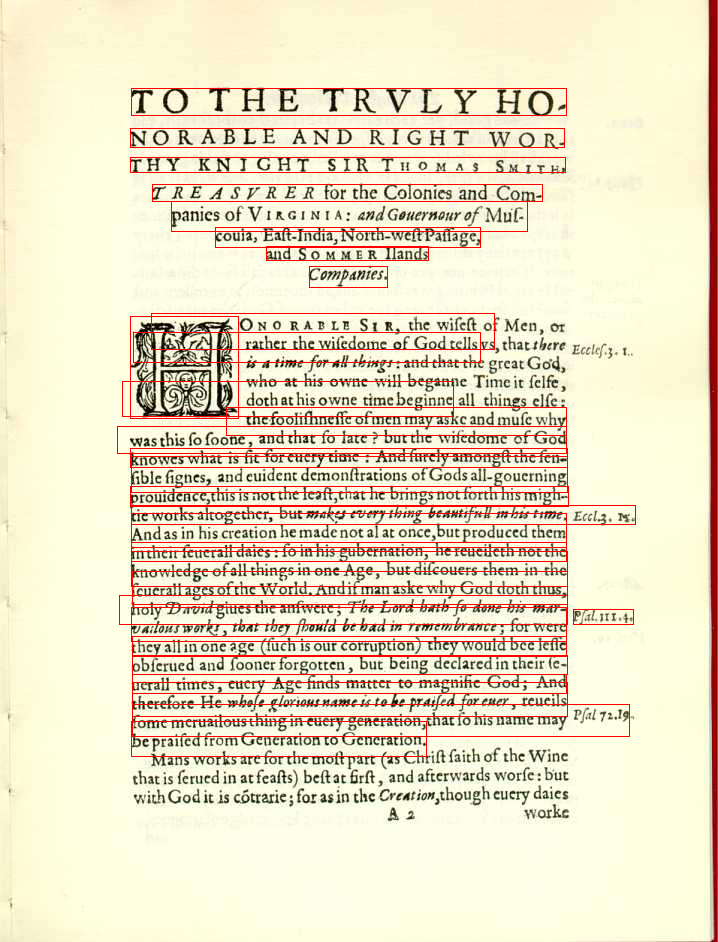

In [140]:
display(image3)

In [141]:
list_of_lines = make_list(text_lines)
graph = construct_graph(list_of_lines)
node_sequence = topological_sort(graph)
display_text(node_sequence, list_of_lines)

TO THE TRVLY HO-
NORABLE AND RIGHT WOR.
THY KNIGHT SIR Tuomas Smitn
TREASVRER for the Colonies and Com-
panics of Vixcinta: and Gouernour of Mul-
couia, Eatt-India, North-weltPaflage,
and Som MER Ilands
Companies.
f ONO RADLE Srp, the wifelt of Men, ot is a time for all things and that the greatGod, Mans works are for the moft part (as Chrift faith of the Wine Aa worke
Y) rather the wifedome of Godtellsvs, that there reese. 4 who at his owne will beganne Time it felfe, thatis ferued in at feafts) beftat firft, and afterwards worfe: but
doth athis owne timebeginne all things elfe: with Godit is cOtrasie; for asin the Creation,though euery daies
~~ thefoolifhneffe ofmen may aske and mufe why
was this fo foone, and that fo late ? burthe wifedome of God
knowes what is fic for euery time : And furely amongft the fen-
fible Agnes, and euidenc demonftrations of Gods all-gouerning,
prouidence,this is notthe leaft,chat he brings not forth his migh-
tie works altogether, but makes every ching be

## Bonus Example

In [142]:
image4 = Image.open('samplepaper2.png')
boxes = pytesseract.image_to_data(image4, output_type=pytesseract.Output.DICT)
boxes = clean_data(boxes)
blocks = seperate_blocks(boxes)
text_lines = seperate_lines(blocks)
for text_line in text_lines:
  get_bounding_boxes(image4, text_line)

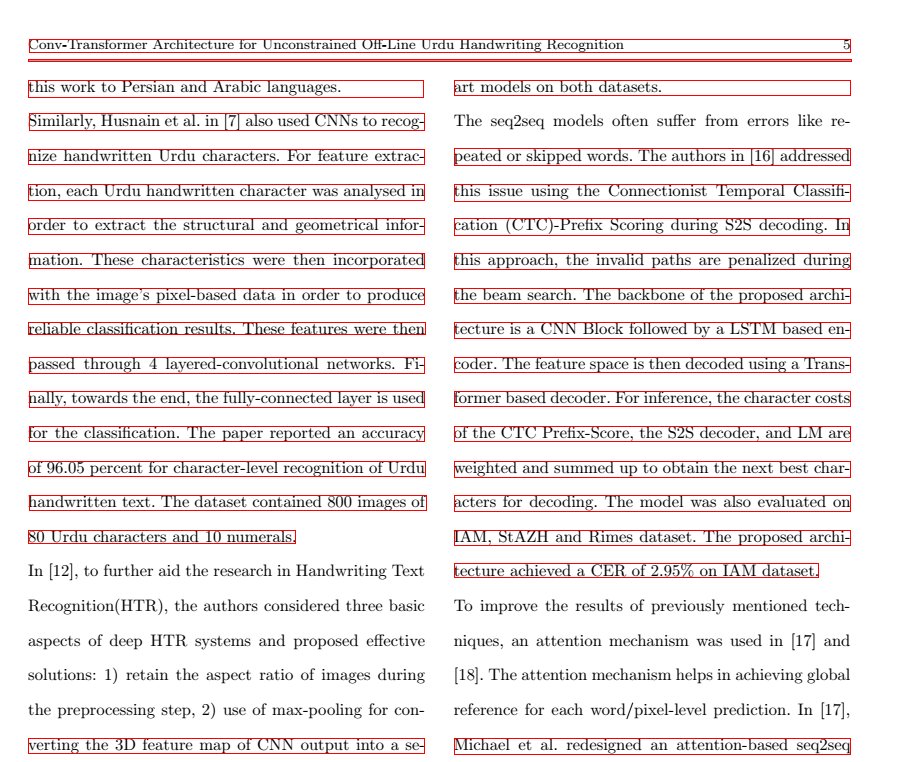

In [143]:
display(image4)

In [144]:
list_of_lines = make_list(text_lines)
graph = construct_graph(list_of_lines)
node_sequence = topological_sort(graph)
display_text(node_sequence, list_of_lines)

Conv-Transformer Architecture for Unconstrained Off-Line Urdu Handwriting Recognition 5
 
this work to Persian and Arabic languages. In [12], to further aid the research in Handwriting Text
Similarly, Husnain et al. in [7] also used CNNs to recog- Recognition(HTR), the authors considered three basic
nize handwritten Urdu characters. For feature extrac- aspects of deep HTR systems and proposed effective
tion, each Urdu handwritten character was analysed in solutions: 1) retain the aspect ratio of images during
order to extract the structural and geometrical infor- the preprocessing step, 2) use of max-pooling for con-
mation. These characteristics were then incorporated
with the image’s pixel-based data in order to produce
reliable classification results. These features were then
passed through 4 layered-convolutional networks. Fi-
nally, towards the end, the fully-connected layer is used
for the classification. The paper reported an accuracy
of 96.05 percent for character-level recogni

# The End